In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
# import data
# create an SQLite database engine named "database.db"
engine = create_engine("sqlite:///resources/database.db")

# query the database to verify the insertion
query = "SELECT * FROM houses"
df = pd.read_sql(query, engine)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Poke around and look at the data

See `./resources/data_description.txt` for details on the data. Roughly, after talking with a few friends that either work in real estate or have bought houses, I would expect the biggest variables to be size of living area, 'location, location, location', number of rooms, age of property, condition of property. Maybe some other randos, like the number of fireplaces and the condition of the kitchen. Year sold probably impacts price - running from 2006-2010, the data set overlaps with the 2008 financial meltdown and housing bubble collapse.

In [3]:
print(f"df shape: {df.shape}")

df shape: (1460, 81)


In [4]:
# disable pandas truncation of output (reset to default before the SalePrice histogram)...
# ...to get, "Output is truncated. View as a scrollable element or open in a text editor"
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
print(f"df data types: \n{df.dtypes}")

df data types: 
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating  

In [7]:
print(f"df uniques: \n{df.nunique()}")

df uniques: 
Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
Street              2
Alley               2
LotShape            4
LandContour         4
Utilities           2
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        15
Exterior2nd        16
MasVnrType          3
MasVnrArea        327
ExterQual           4
ExterCond           5
Foundation          6
BsmtQual            4
BsmtCond            4
BsmtExposure        4
BsmtFinType1        6
BsmtFinSF1        637
BsmtFinType2        6
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
Heating             6
HeatingQC           5
CentralAir          2
Electrical          5
1stFlrSF          753
2ndFlrSF          4

In [8]:
# Check for missing values
print(f"Missing Values in Train Data:\n{df.isnull().sum()}")


Missing Values in Train Data:
Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2n

In [9]:
# reset pandas truncation to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [10]:
# the target
print(f"median: {df.SalePrice.median()}")
df.SalePrice.describe()

median: 163000.0


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

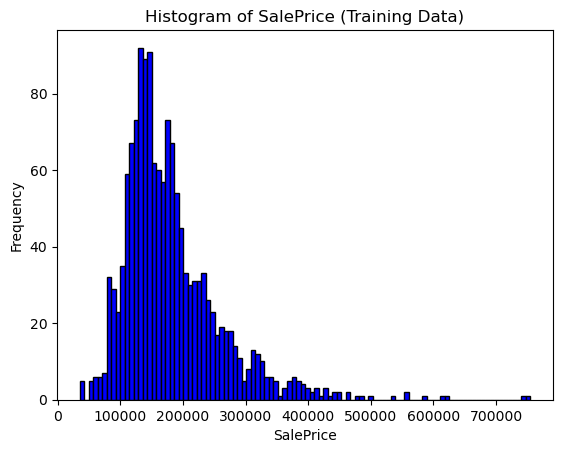

In [11]:
# Plot histogram of SalePrice, the target
plt.hist(df['SalePrice'], bins=100, color='blue', edgecolor='black')

# format
plt.title('Histogram of SalePrice (Training Data)')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.show()

The histograms show a fairly normal distribution, but with a long tail at the right - potential outliers

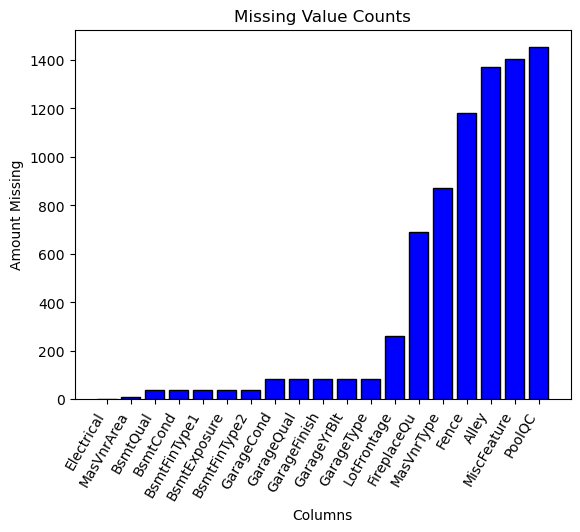

In [12]:
# plot missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing = missing.sort_values()
plt.bar(missing.index, missing.values, color='blue', edgecolor='black')

# add missing value counts to chart
for i, value in enumerate(missing.values):
    plt.text(i, value + 10, str(value), ha='center', va='bottom', color='black', fontsize=8)

# format plot
plt.title('Missing Value Counts')
plt.xlabel("Columns")
plt.ylabel("Amount Missing")
plt.xticks(rotation=60, ha='right')

plt.show()

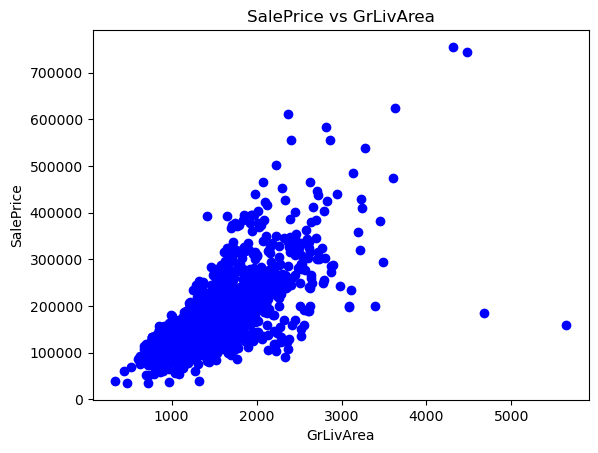

In [13]:
# plot above ground living area versus sales price
plt.scatter(df.GrLivArea, df.SalePrice, color="blue")

# format
plt.title('SalePrice vs GrLivArea')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.show()

The values above 4000 square feet are outliers. Doesn't mean there aren't other outliers, but i'll be careful for now.

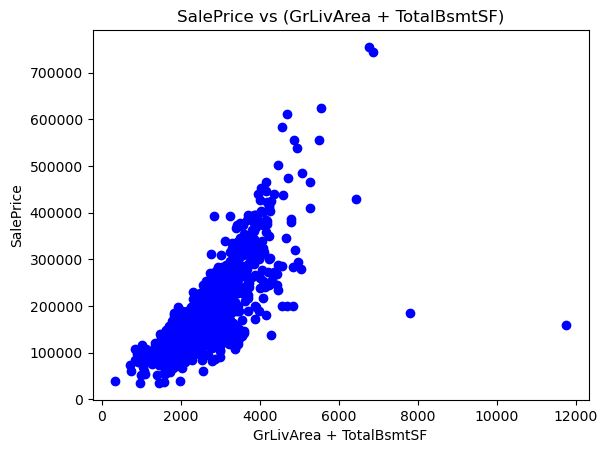

In [14]:
# same, but with basement square feet added
plt.scatter(df.GrLivArea + df.TotalBsmtSF, df.SalePrice, color="blue")

# format
plt.title('SalePrice vs (GrLivArea + TotalBsmtSF)')
plt.xlabel('GrLivArea + TotalBsmtSF')
plt.ylabel('SalePrice')

plt.show()

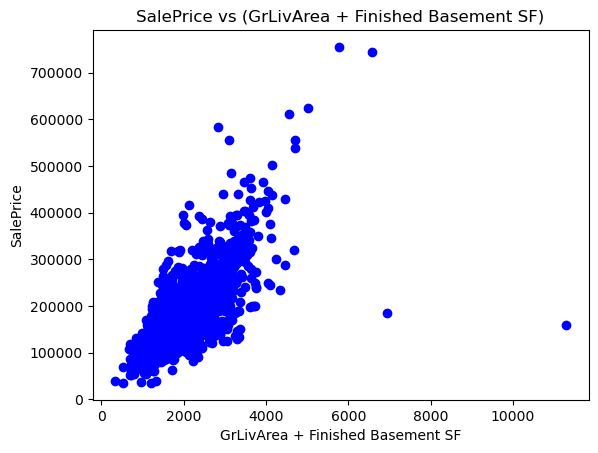

In [15]:
# same, but with basement square feet added
plt.scatter(df.GrLivArea + df.TotalBsmtSF - df.BsmtUnfSF, df.SalePrice, color="blue")

# format
plt.title('SalePrice vs (GrLivArea + Finished Basement SF)')
plt.xlabel('GrLivArea + Finished Basement SF')
plt.ylabel('SalePrice')

plt.show()

In [16]:
df.Neighborhood.value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64

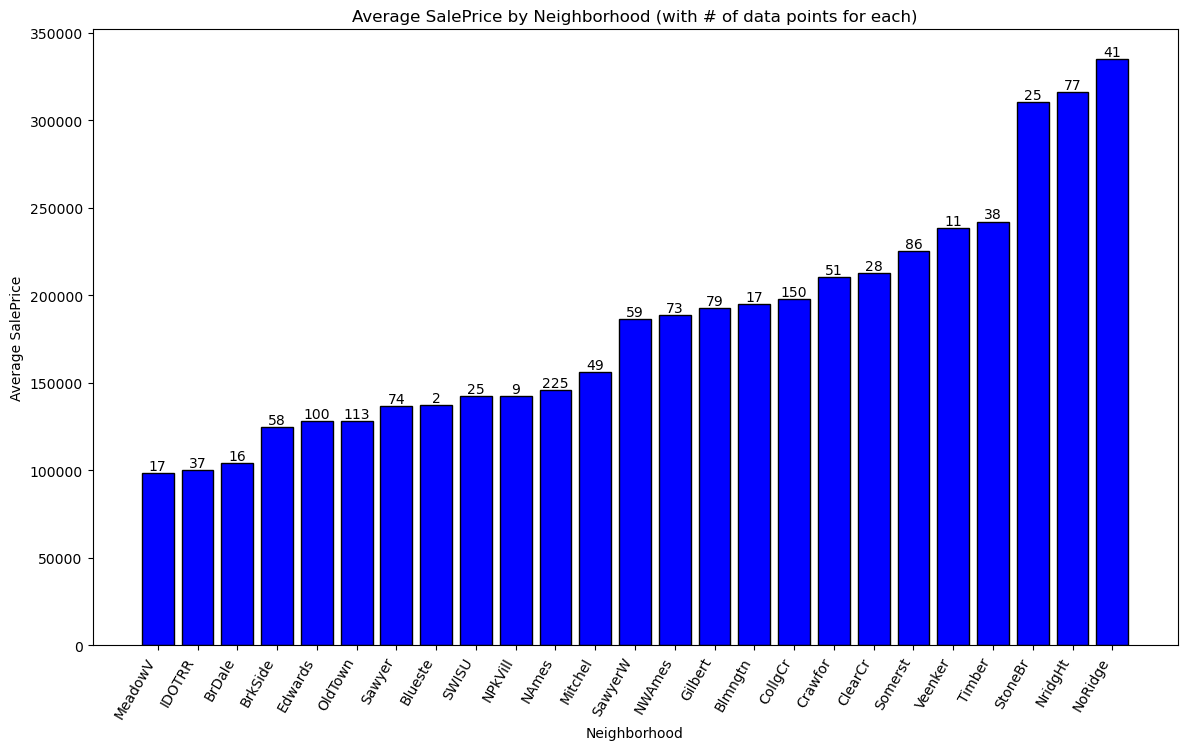

In [17]:
# plot Neighborhood versus SalePrice
# groupby neighborhood
neighborhood_prices = df.groupby('Neighborhood')['SalePrice'].mean().sort_values()

# get neighborhood counts to display
neighborhood_counts = df.Neighborhood.value_counts().reindex(neighborhood_prices.index)

# plot the chart
plt.figure(figsize=(14, 8))
bars = plt.bar(neighborhood_prices.index, neighborhood_prices.values, color='blue', edgecolor='black')

# add neighborhood value counts to chart
for bar, count in zip(bars, neighborhood_counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom', color='black')

# format
plt.title('Average SalePrice by Neighborhood (with # of data points for each)')
plt.xlabel('Neighborhood')
plt.ylabel('Average SalePrice')
plt.xticks(rotation=60, ha='right')

plt.show()

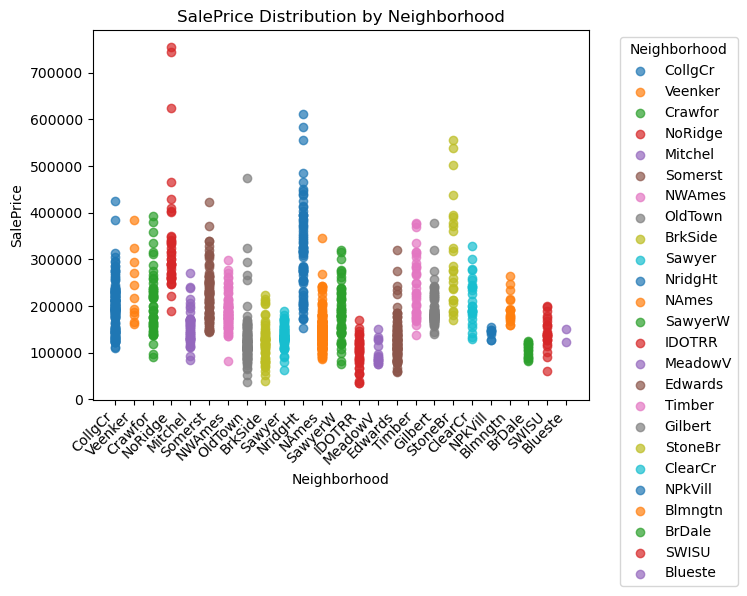

In [18]:
# Iterate over unique neighborhoods and plot strip plot
neighborhoods = df.Neighborhood.unique()

# Plot each data point for each neighborhood
for i, neighborhood in enumerate(neighborhoods):
    neighborhood_data = df[df['Neighborhood'] == neighborhood]
    plt.scatter([i] * len(neighborhood_data), neighborhood_data.SalePrice, label=neighborhood, alpha=0.7)

# Customize the plot
plt.title('SalePrice Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')
plt.xticks(range(len(neighborhoods)), neighborhoods, rotation=45, ha='right')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

The lack of data in some neighborhoods is troubling. How to 'location, location, location'? Just get_dummies it this first time around and see what happens?

Look at the sales conditions - what does Normal mean?

In [19]:
df.SaleCondition.value_counts()

SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64

In [20]:
print("Mean Sale Price: ", df.SalePrice.mean())
print("Mean Sale Price for 'Normal' condition:", df[df.SaleCondition == 'Normal']['SalePrice'].mean())
print("Mean Sale Price for 'Abnormal' condition:", df[df.SaleCondition == 'Abnorml']['SalePrice'].mean())
print("Mean Sale Price for 'Family' condition:", df[df.SaleCondition == 'Family']['SalePrice'].mean())
print("Mean Sale Price for 'Partial' condition:", df[df.SaleCondition == 'Partial']['SalePrice'].mean())
print("Mean Sale Price for 'Alloc' condition:", df[df.SaleCondition == 'Alloc']['SalePrice'].mean())
print("Mean Sale Price for 'AdjLand' condition:", df[df.SaleCondition == 'AdjLand']['SalePrice'].mean())


Mean Sale Price:  180921.19589041095
Mean Sale Price for 'Normal' condition: 175202.21953255427
Mean Sale Price for 'Abnormal' condition: 146526.62376237623
Mean Sale Price for 'Family' condition: 149600.0
Mean Sale Price for 'Partial' condition: 272291.752
Mean Sale Price for 'Alloc' condition: nan
Mean Sale Price for 'AdjLand' condition: 104125.0


Consider dropping all values besides Normal

In [21]:
# display numerical features
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


N.B. - every one of these plots has a button in the top right that can be clicked to expand it, so you can look at the data closer. There's a lot going on here, a lot to digest.

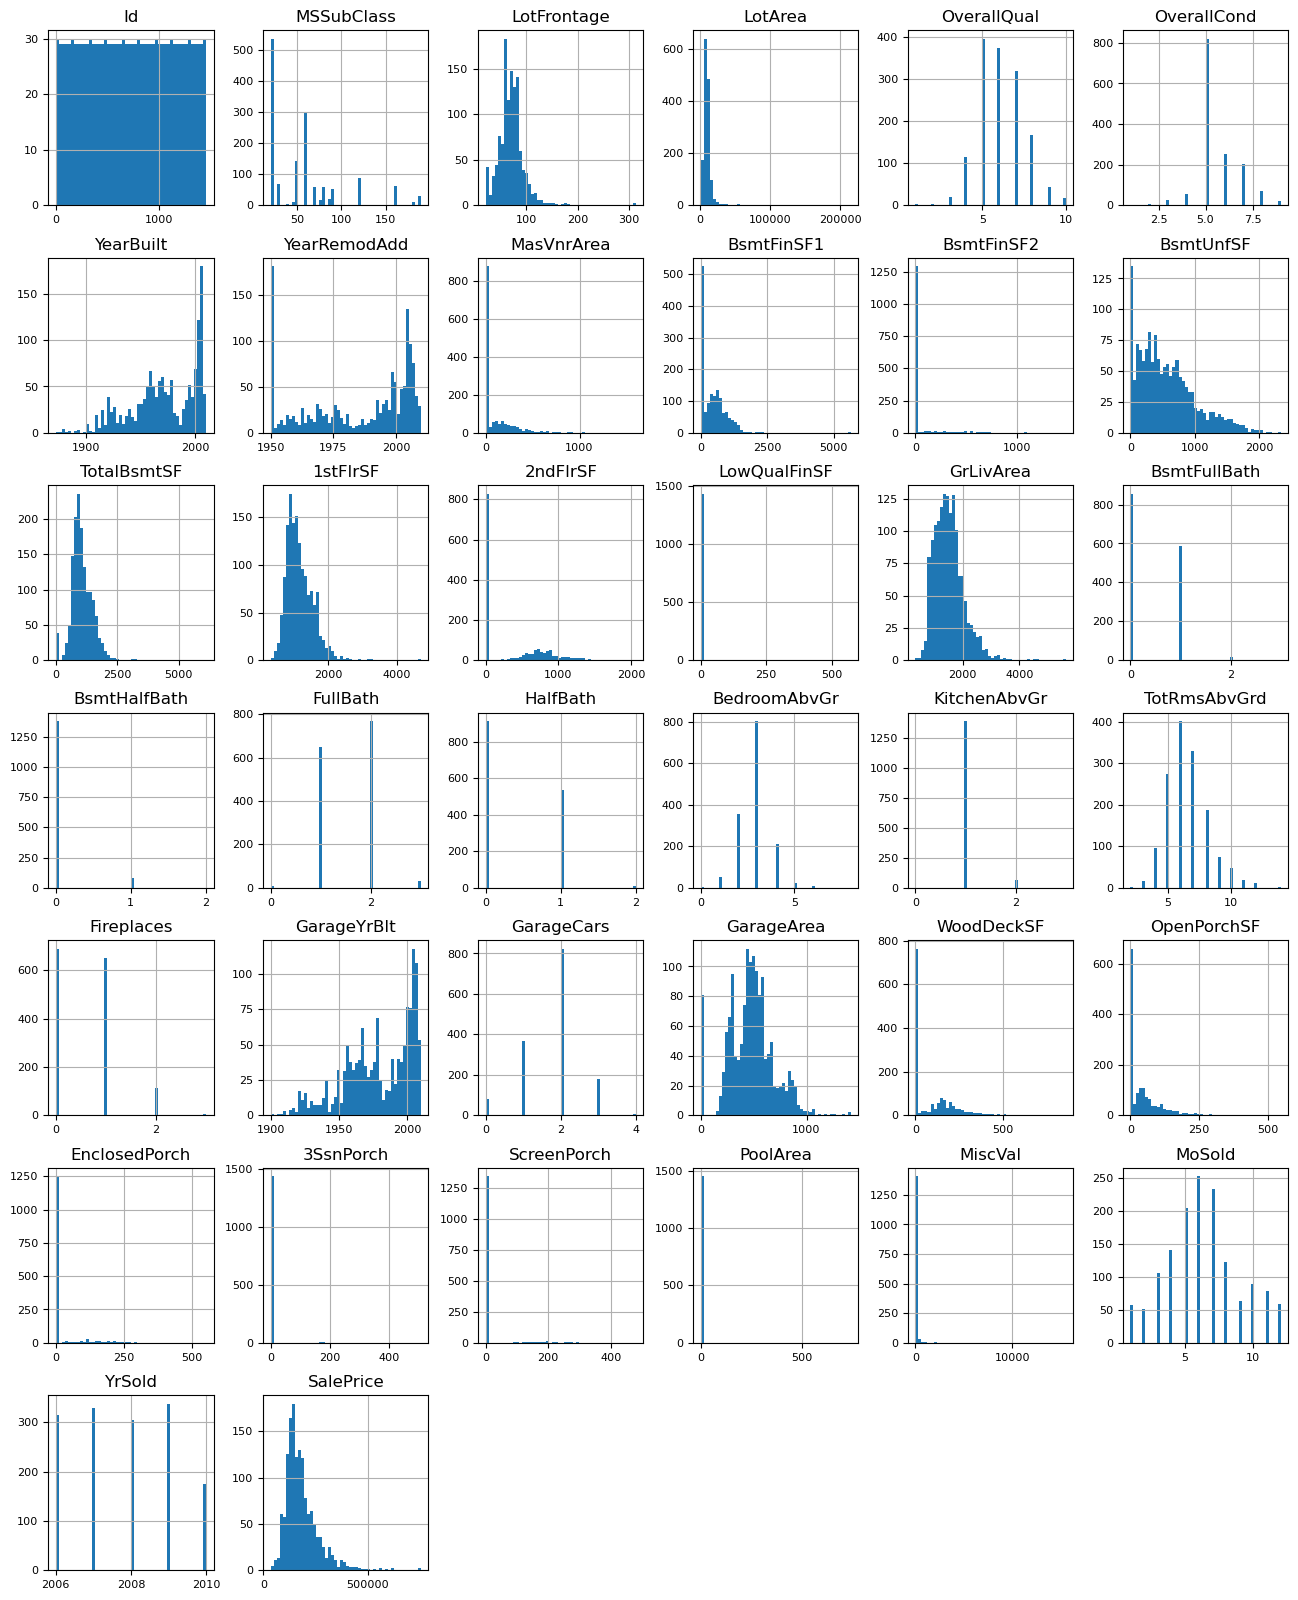

In [22]:
# histogram of all numerical features, just to see
# keep the semicolon to suppress a bunch of annoying text output
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

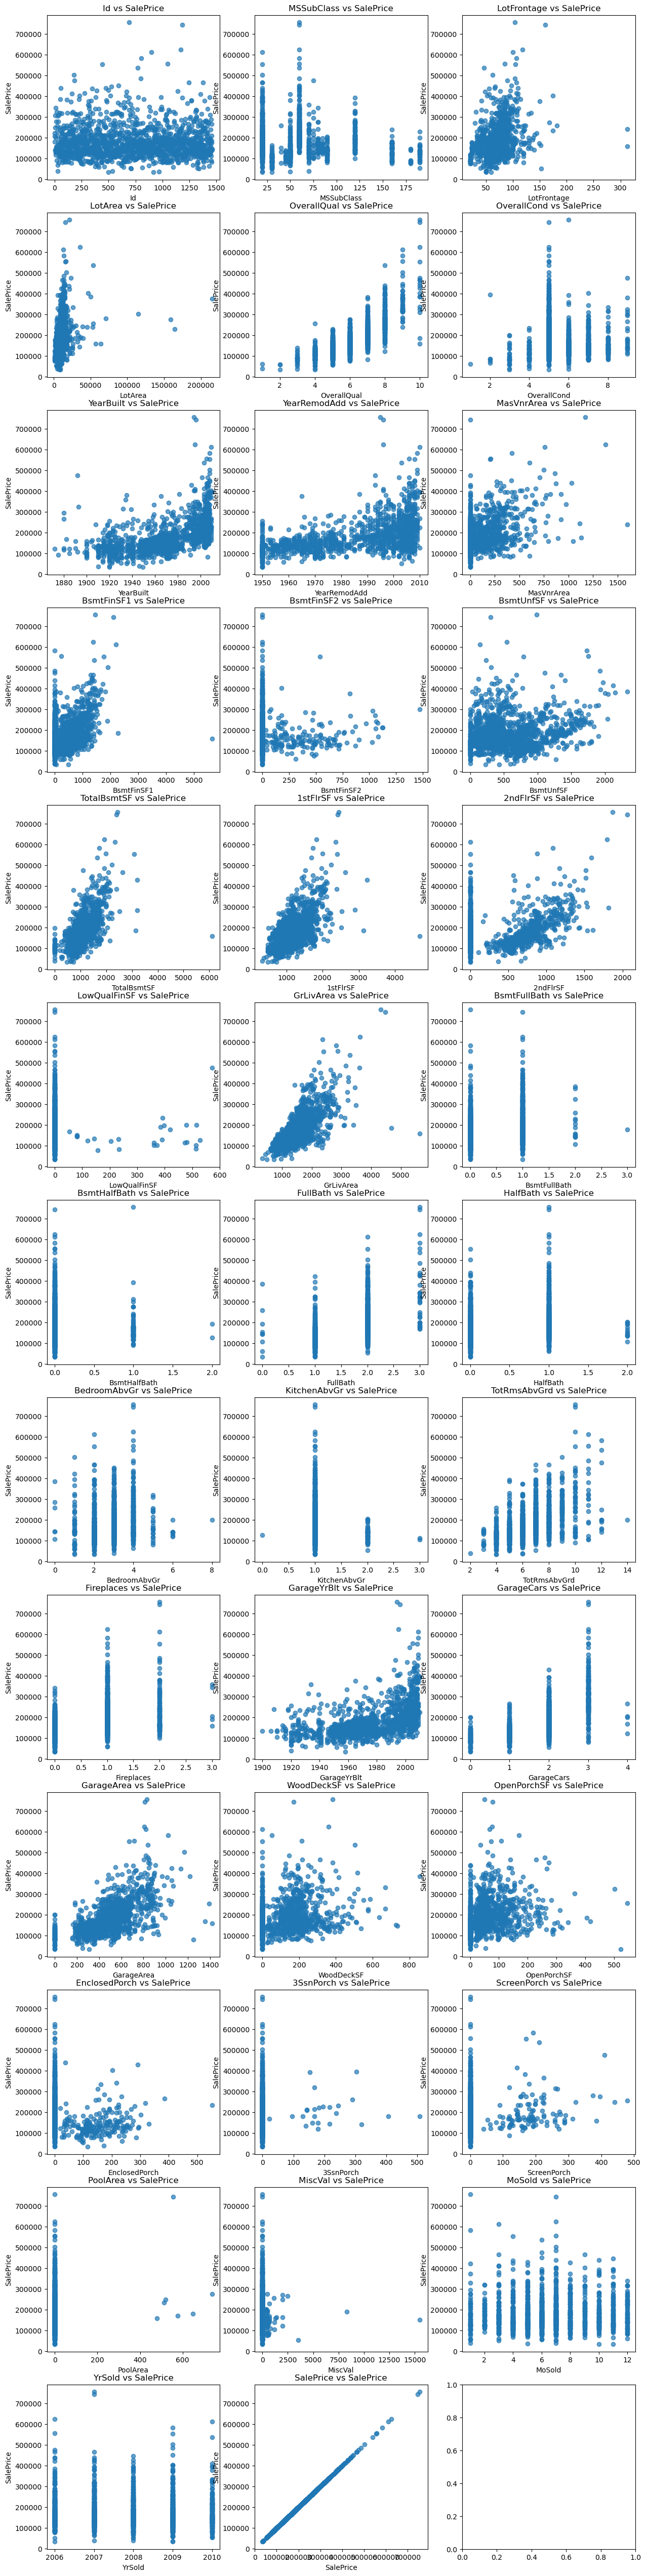

In [23]:
# plot each numerical feature against sale price
num_features = df_num.columns

# Define the number of columns in the grid
num_cols = 3

# Calculate the number of rows needed
num_rows = (len(num_features) + num_cols - 1) // num_cols

# Create subplots with multiple line plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through each numerical variable and create line plots
for i, variable in enumerate(num_features):
    ax = axes[i]
    ax.scatter(df_num[variable], df_num['SalePrice'], label=f'{variable} vs SalePrice', alpha=0.7)
    ax.set_title(f'{variable} vs SalePrice')
    ax.set_xlabel(variable)
    ax.set_ylabel('SalePrice')

# Show the plot
plt.show()

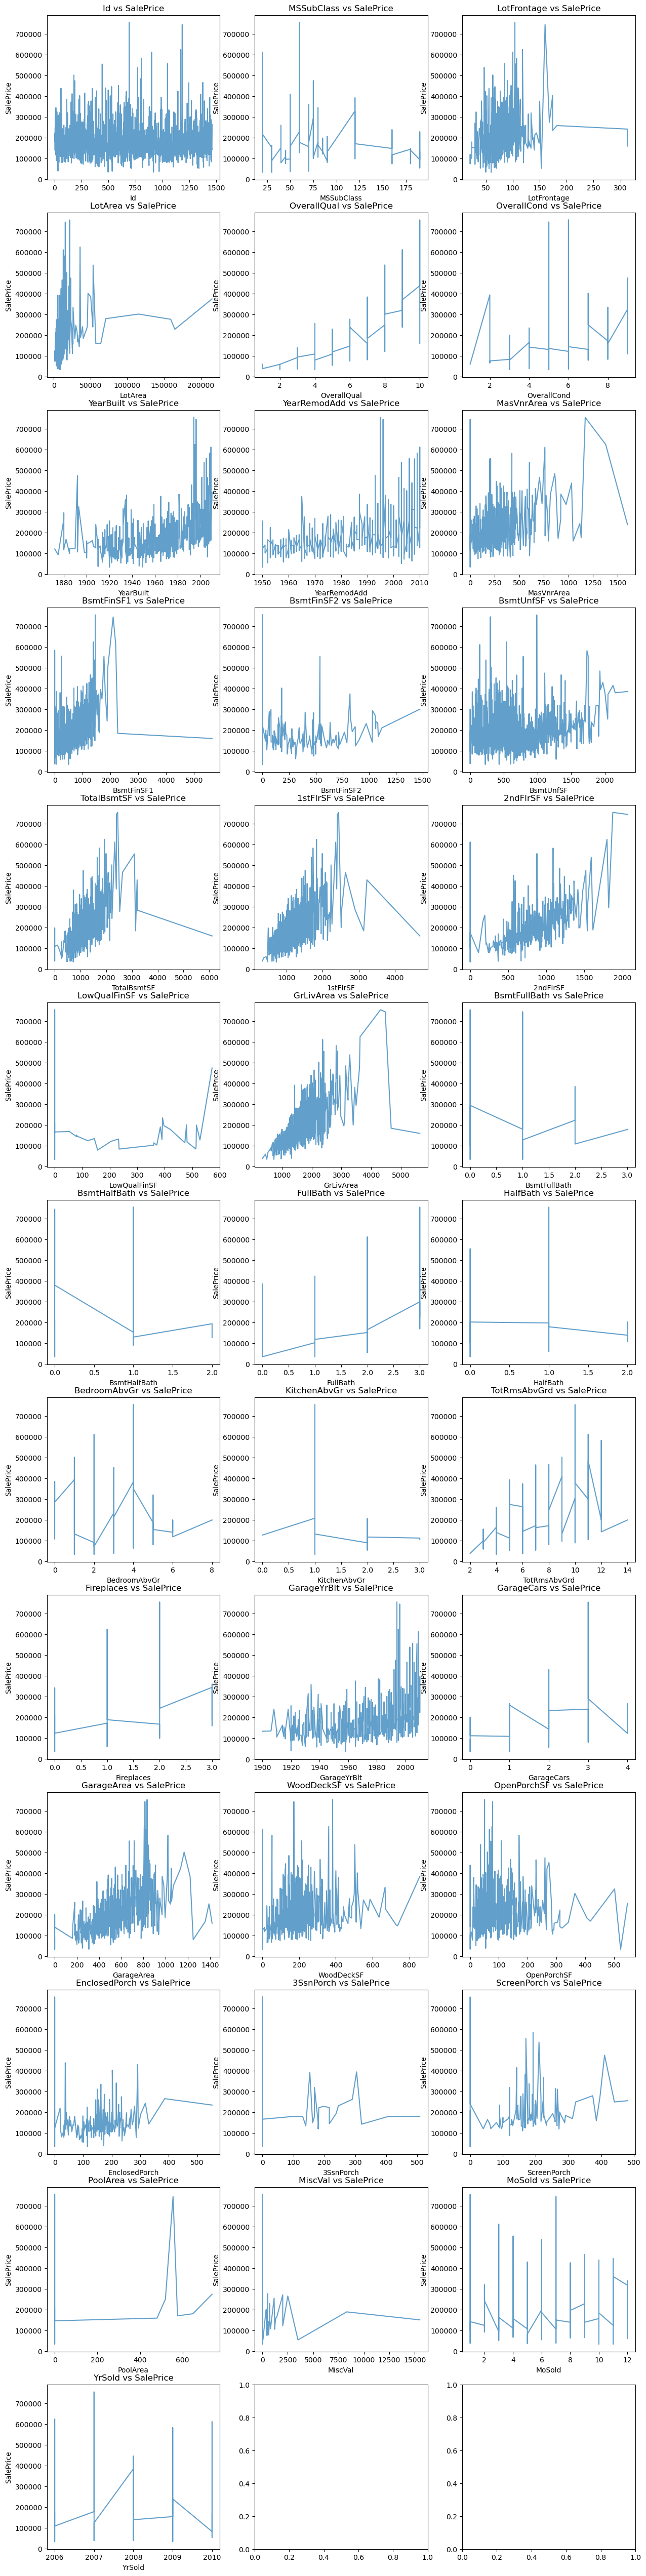

In [24]:
# line plot of numerical features versus SalePrice
# remove 'SalePrice' from the list of numerical variables...
# ...to prevent an annoying error
num_features = [var for var in num_features if var != 'SalePrice']

# define the number of columns and rows in the grid
num_cols = 3
num_rows = (len(num_features) + num_cols - 1) // num_cols

# create subplots with multiple line plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# flatten the axes array for easier indexing
axes = axes.flatten()

# iterate through each numerical variable and create sorted line plots
for i, variable in enumerate(num_features):
    ax = axes[i]
    sorted_df = df_num[[variable, 'SalePrice']].sort_values(by=variable)
    ax.plot(sorted_df[variable], sorted_df.SalePrice, label=f'{variable} vs SalePrice', alpha=0.7)
    ax.set_title(f'{variable} vs SalePrice')
    ax.set_xlabel(variable)
    ax.set_ylabel('SalePrice')

plt.show()

A LOT going on there, but there are some obvious trends. 

OverallQual and (somewhat OverallCond) seem highly explanatory. 

Anything with square footage seems to help (except, maybe oddly, LotArea), although basement details are weaker. TotaBsmtSF, 1stFlrSf, 2ndFlrSF, GrLivArea, GarageArea seem explanatory.

Rooms seems explanatory, as expected. FullBath, HalfBath, BedroomAbvGr, TotRmsAbvGrd. GarageCars is kind of like a room count.

YearBuilt and YearRemodAdd seem explanatory, which makes sense. GarageYrBlt, maybe?

Misc: Fireplaces. Huh. Cool.

I don't know what to do about the 2008 housing market collapse yet, You can see it in the data., but not as strong as I expected. Or housing prices recovered quicker than I remember.

Outlier warning: when you look at those charts, you'll always see those two houses that sold for over $700,000 all over.

Seems like OverallQual and GrLivArea are the most important. Let's find out!

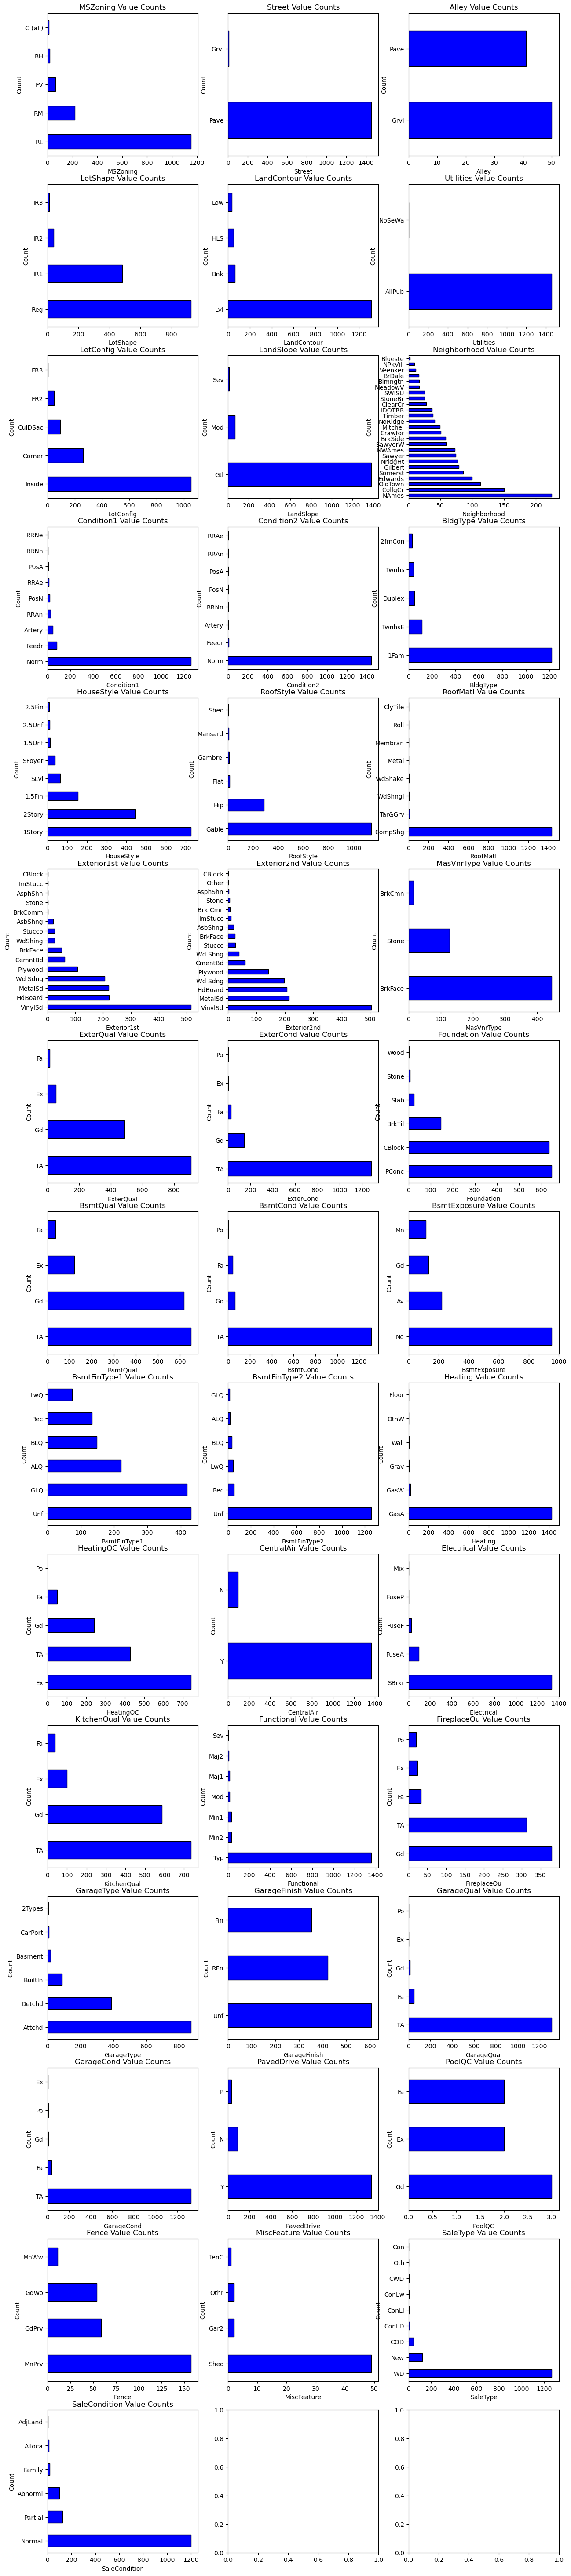

In [25]:
# plot categorical features
cat_features = df.select_dtypes(include=['object']).columns

# define the number of columns and rows in the grid
num_cols = 3
num_rows = (len(cat_features) + num_cols - 1) // num_cols

# create subplots with multiple bar plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through each categorical variable and create bar plots
for i, feature in enumerate(cat_features):
    ax = axes[i]
    feature_counts = df[feature].value_counts()
    feature_counts.plot(kind='barh', ax=ax, color='blue', edgecolor='black')
    ax.set_title(f'{feature} Value Counts')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Show the plot
plt.show()

That'll give us some idea of what to drop, and rare features for categories. Note that it does not include 'NA', which is a big deal for some of these (compare with missing values plot above - PoolQC, MiscFeature, Alley, Fence, MasVnrType, FireplaceQU being the most prominent)

## Data Preprocessing

Dry run. Fill missing df_num variables with the mean (could do median). Drop Id. It's useless. Remove properties above 4000 square feet GrLivArea (outliers). After running this, we'll get around to tweaking features. Drop some stuff. Recategorize stuff. etc. No idea how to deal with the 2008 crash yet.

In [26]:
# fill missing values with the mean
# yeah, shot in the dark here
df = df.fillna(df_num.mean())

In [27]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [28]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1456 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1456 non-null   int64  
 1   MSZoning       1456 non-null   object 
 2   LotFrontage    1456 non-null   float64
 3   LotArea        1456 non-null   int64  
 4   Street         1456 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1456 non-null   object 
 7   LandContour    1456 non-null   object 
 8   Utilities      1456 non-null   object 
 9   LotConfig      1456 non-null   object 
 10  LandSlope      1456 non-null   object 
 11  Neighborhood   1456 non-null   object 
 12  Condition1     1456 non-null   object 
 13  Condition2     1456 non-null   object 
 14  BldgType       1456 non-null   object 
 15  HouseStyle     1456 non-null   object 
 16  OverallQual    1456 non-null   int64  
 17  OverallCond    1456 non-null   int64  
 18  YearBuilt    

And we have dropped four outliers

In [29]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False


That's probably way too many dummies.

In [30]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training and testing sets
# shout out to Douglas Adams - so long, thanks for all the fish, don't forget your towel
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train, Evaluate the Model

In [32]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 580
hidden_nodes_layer2 = 200

nn = tf.keras.models.Sequential()

# bares bones nn (for testing)
# nn.add(tf.keras.layers.Dense(units=1, input_dim=number_input_features, activation="linear"))

# First hidden layer
nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"
    )
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
# going with linear, as this is a linear regression problem
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 580)               166460    
                                                                 
 dense_1 (Dense)             (None, 200)               116200    
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 282861 (1.08 MB)
Trainable params: 282861 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [34]:
# Train the model
fit_model = nn.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    validation_data=(X_test_scaled, y_test),
)

Epoch 1/100




35/35 [==============================] - 2s 10ms/step - loss: 38480199680.0000 - mse: 38480199680.0000 - val_loss: 37759946752.0000 - val_mse: 37759946752.0000
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 38268104704.0000 - mse: 38268104704.0000 - val_loss: 37282529280.0000 - val_mse: 37282529280.0000
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 37285396480.0000 - mse: 37285396480.0000 - val_loss: 35641286656.0000 - val_mse: 35641286656.0000
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 34747232256.0000 - mse: 34747232256.0000 - val_loss: 32150765568.0000 - val_mse: 32150765568.0000
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 30217908224.0000 - mse: 30217908224.0000 - val_loss: 26616309760.0000 - val_mse: 26616309760.0000
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 24025028608.0000 - mse: 24025028608.0000 - val_loss: 19902658560.0000 - val_mse: 1

In [35]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, nn.predict(X_test_scaled))}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, nn.predict(X_test_scaled))}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, nn.predict(X_test_scaled))}")

12/12 [==============================] - 0s 1ms/step
R-squared: 0.8141999536192069
12/12 [==============================] - 0s 2ms/step
Mean Squared Error: 1177487545.301782
12/12 [==============================] - 0s 1ms/step
Mean Absolute Error: 22073.388741629464


It's an R-squared approaching .8 (I've gotten everything from .67 to .87). The mean absolute error is bothersome. Many of these houses are around $200,000, so a $20,000 mean absolute error amounts to about 10%. That right tail certainly skews it (the houses that cost a LOT of money). Not sure what to do about that.

Well, not bad for a lazy dry run. We can make it better. Ideas for improvement include batching features together (like square footage). No clue what to do for location. We should definitely drop some features.

In [36]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
# suddenly the mean absolute error seems quite a bit better
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}")
print(f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}")

Baseline R-squared: -0.0020358188061133653
Baseline Mean Squared Error: 6350292799.025054
Baseline Mean Absolute Error: 57802.67051583946


In [37]:
# predict a baseline, but with the median
import numpy as np
baseline_prediction = np.median(y_train)

# create array of baseline predictions with the length of y_test
baseline_predictions = np.full_like(y_test, fill_value=baseline_prediction)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}")
print(f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}")

Baseline R-squared: -0.02752440292590852
Baseline Mean Squared Error: 6511823923.118132
Baseline Mean Absolute Error: 55197.854395604394
